In [4]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [5]:
train_path = "house-prices-data/train.csv"
test_path = "house-prices-data/test.csv"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [6]:
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [7]:
outliers = [598, 955, 935, 1299, 250, 314, 336, 707, 379, 1183, 692, 186, 441, 186, 524, 739, 598, 955, 636, 1062, 1191, 496, 198]

# results of manual outlier detection in another notebook

In [8]:
train = train[train.Id.isin(outliers) == False]

In [9]:
# dealing with null values

pd.DataFrame(train.isnull().sum().sort_values(ascending=False)).head(20)

,0
PoolQC,1436
MiscFeature,1389
Alley,1350
Fence,1163
MasVnrType,862
FireplaceQu,685
LotFrontage,255
GarageYrBlt,77
GarageCond,77
GarageType,77


In [10]:
train['Alley'].fillna('No', inplace=True)
test['Alley'].fillna('No', inplace=True)

train['Fence'].fillna('No', inplace=True)
test['Fence'].fillna('No', inplace=True)

train['MasVnrType'].fillna('No', inplace=True)
test['MasVnrType'].fillna('No', inplace=True)

train['MasVnrArea'].fillna(0, inplace=True)
test['MasVnrArea'].fillna(0, inplace=True)

train['FireplaceQu'].fillna('No', inplace=True)
test['FireplaceQu'].fillna('No', inplace=True)

train['LotFrontage'].fillna(0, inplace=True)
test['LotFrontage'].fillna(0, inplace=True)

train['GarageCond'].fillna('No', inplace=True)
test['GarageCond'].fillna('No', inplace=True)

train['GarageType'].fillna('No', inplace=True)
test['GarageType'].fillna('No', inplace=True)

train['GarageFinish'].fillna('No', inplace=True)
test['GarageFinish'].fillna('No', inplace=True)

train['GarageQual'].fillna('No', inplace=True)
test['GarageQual'].fillna('No', inplace=True)

train['BsmtFinType2'].fillna('No', inplace=True)
test['BsmtFinType2'].fillna('No', inplace=True)

train['BsmtExposure'].fillna('NoBasement', inplace=True)
test['BsmtExposure'].fillna('NoBasement', inplace=True)

train['BsmtQual'].fillna('No', inplace=True)
test['BsmtQual'].fillna('No', inplace=True)

train['BsmtCond'].fillna('No', inplace=True)
test['BsmtCond'].fillna('No', inplace=True)

train['BsmtFinType1'].fillna('No', inplace=True)
test['BsmtFinType1'].fillna('No', inplace=True)

train['Electrical'].fillna('SBrkr', inplace=True)
test['Electrical'].fillna('SBrkr', inplace=True)

/var/folders/h8/6fttj9fn14ngd88m_dg7zdn40000gn/T/ipykernel_66700/3422501790.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Alley'].fillna('No', inplace=True)
/var/folders/h8/6fttj9fn14ngd88m_dg7zdn40000gn/T/ipykernel_66700/3422501790.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beha

In [11]:
train = train.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'GarageYrBlt', 'GarageCond', 'BsmtFinType2'])
test = test.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'GarageYrBlt', 'GarageCond', 'BsmtFinType2'])

In [15]:
# Feature Engineering

train['HouseAge'] = train['YrSold'] - train['YearBuilt']
test['HouseAge'] = test['YrSold'] - test['YearBuilt']

train['HouseRemodelAge'] = train['YrSold'] - train['YearRemodAdd']
test['HouseRemodelAge'] = test['YrSold'] - test['YearRemodAdd']

train['TotalSqFt'] = train['1stFlrSF'] + train['2ndFlrSF'] + train['BsmtFinSF1'] + train['BsmtFinSF2']
test['TotalSqFt'] = test['1stFlrSF'] + test['2ndFlrSF'] + test['BsmtFinSF1'] + test['BsmtFinSF2']

train['TotalArea'] = train['GrLivArea'] + train['TotalBsmtSF']
test['TotalArea'] = test['GrLivArea'] + test['TotalBsmtSF']

train['TotalBaths'] = train['BsmtFullBath'] + train['FullBath'] + 0.5 * (train['BsmtHalfBath']) + train['HalfBath']
test['TotalBaths'] = test['BsmtFullBath'] + test['FullBath'] + 0.5 * (test['BsmtHalfBath']) + test['HalfBath']

train['TotalPorchSqFt'] = train['OpenPorchSF'] + train['3SsnPorch'] + train['EnclosedPorch'] + train['ScreenPorch'] + train['WoodDeckSF']
test['TotalPorchSqFt'] = test['OpenPorchSF'] + test['3SsnPorch'] + test['EnclosedPorch'] + test['ScreenPorch'] + test['WoodDeckSF']

In [16]:
train = train.drop(columns=['Id','YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'])
test = test.drop(columns=['YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'])

In [18]:
train = train.drop(columns=['GarageArea'])
test = test.drop(columns=['GarageArea'])

<Axes: >

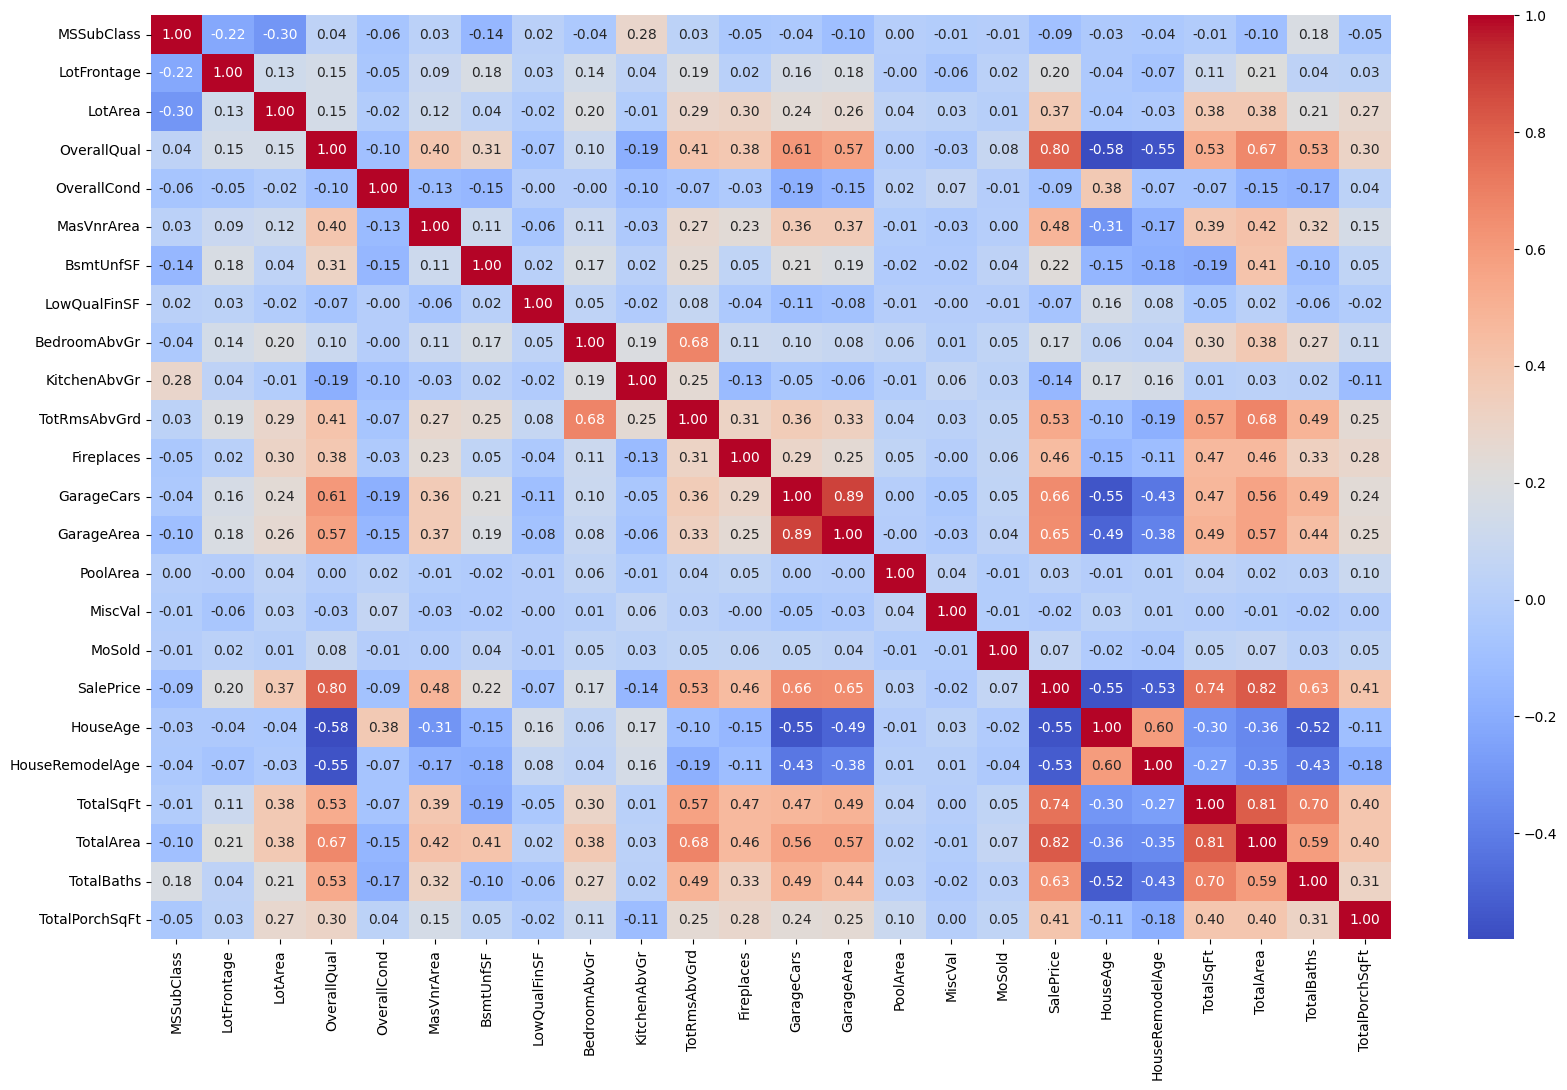

In [17]:
correlation_matrix = train.corr(numeric_only=True)
plt.figure(figsize=(20,12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice', ylabel='Count'>

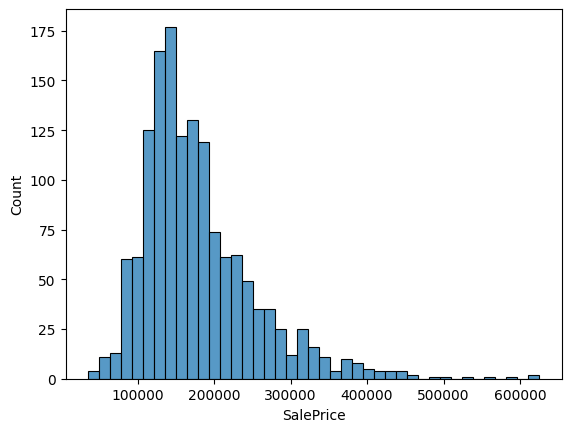

In [19]:
# Transforming label

sns.histplot(train, x=train['SalePrice'])

In [20]:
train['SalePrice'] = np.log1p(train['SalePrice'])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice', ylabel='Count'>

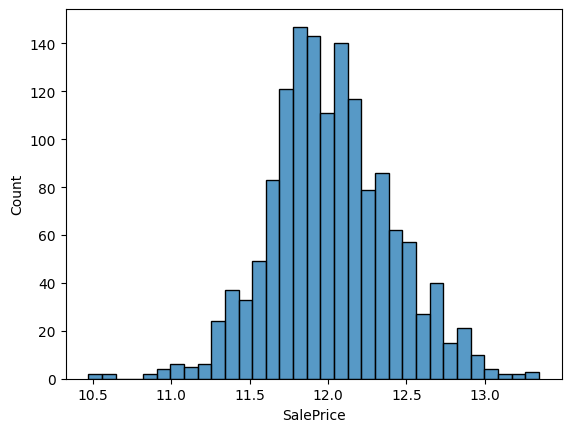

In [21]:
sns.histplot(train, x=train['SalePrice'])


In [22]:
#encoding

In [23]:
# ordinal encoding 

ode_cols = ['LotShape', 'LandContour','Utilities','LandSlope',  'BsmtQual',  'BsmtFinType1',  'CentralAir',  'Functional', \
           'FireplaceQu', 'GarageFinish', 'GarageQual', 'PavedDrive', 'ExterCond', 'KitchenQual', 'BsmtExposure', 'HeatingQC','ExterQual', 'BsmtCond']

In [24]:
ohe_cols = ['Street', 'LotConfig','Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', \
           'MasVnrType','Foundation',  'Electrical',  'SaleType', 'MSZoning', 'SaleCondition', 'Heating', 'GarageType', 'RoofMatl']

In [25]:
num_cols = train.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop('SalePrice')

In [27]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [28]:
ode_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

In [29]:
ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [32]:
col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('ode_p', ode_pipeline, ode_cols),
    ('ohe_p', ohe_pipeline, ohe_cols),
    ],
    remainder='passthrough', 
    n_jobs=-1)

In [33]:
pipeline = Pipeline(steps=[
    ('preprocessing', col_trans)
])

In [34]:
X = train.drop('SalePrice', axis=1)
y = train['SalePrice']

In [35]:
X_preprocessed = pipeline.fit_transform(X)

In [36]:
# val split

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=23)

In [37]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [38]:
y_pred_lr = lr.predict(X_test)

In [39]:
mean_squared_error(y_test, y_pred_lr)

8.36658817089578e+16

In [40]:
rfr = RandomForestRegressor(max_depth=20, min_samples_split=2, n_estimators=1000, random_state=23)

In [41]:
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=1000, random_state=23)

In [42]:
rfr_pred = rfr.predict(X_test)

In [43]:
rfr_score = mean_squared_error(y_test, rfr_pred)
rfr_score

0.01740349904976626

In [44]:
xgb = XGBRegressor(random_state=23)

In [45]:
param_grid_XGB = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [300],
    'max_depth': [3],
    'min_child_weight': [1,2,3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

In [46]:
xgb_cv = GridSearchCV(xgb, param_grid=param_grid_XGB, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [47]:
xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=23, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.05, 0.1, 0.2], 'max_depth': [3],
                         'min_child_weight': [1, 2, 3], 'n_estimators': [300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_squared_error')

In [48]:
xgb_pred = xgb_cv.predict(X_test)

In [49]:
xgb_cv.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 300,
 'subsample': 0.9}

In [50]:
xgb_cv_score = mean_squared_error(y_true=y_test, y_pred=xgb_pred)
xgb_cv_score

0.013839275017064093

In [52]:
# Finalization

df_test_preprocess = pipeline.transform(test)

In [54]:
y_final = np.exp(xgb_cv.predict(df_test_preprocess))

df_y_out = test[['Id']]
df_y_out['SalePrice'] = y_final

df_y_out.to_csv('submission.csv', index=False)

/var/folders/h8/6fttj9fn14ngd88m_dg7zdn40000gn/T/ipykernel_66700/1332883066.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_out['SalePrice'] = y_final
